In [1]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import os
from skimage.feature import local_binary_pattern
import cv2


In [2]:

# Function to resize and pad the image while preserving the aspect ratio
def resize_and_pad_image(img, desired_size=224):
    old_size = img.size
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size, Image.LANCZOS)

    new_img = Image.new("RGB", (desired_size, desired_size))
    new_img.paste(img, ((desired_size - new_size[0]) // 2, (desired_size - new_size[1]) // 2))
    return new_img


In [3]:
# Define the Dataset class
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0] + ".png")
        image = Image.open(img_name)
        image = resize_and_pad_image(image, desired_size=224)
        label = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [4]:
# Load the test dataset
test_images_directory = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'test_images')
test_csv_file = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'test.csv')

test_dataset = FundusDataset(csv_file=test_csv_file, img_dir=test_images_directory, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load the ResNet-18 model architecture
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # Multiclass classification with 5 outputs

# Load the trained weights
trained_resnet_model = os.path.join('..', '..', 'Models', 'weighted_multiclass_resnet.pth')
model.load_state_dict(torch.load(trained_resnet_model))

# Set the model to evaluation mode
model.eval()

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to store true labels and predictions
all_labels = []
all_preds = []


c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Kaylin\AppData\Local\Temp\ipykernel_18272\1030051832.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute

In [5]:
# Testing loop
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

In [6]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 69.95%


In [8]:
# Calculate F1 score (macro average, for multiclass)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (Macro): {f1:.2f}")

F1 Score (Macro): 0.46


In [9]:
# Calculate Precision and Recall (macro average)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
print(f"Precision (Macro): {precision:.2f}")
print(f"Recall (Macro): {recall:.2f}")

Precision (Macro): 0.62
Recall (Macro): 0.47


In [10]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       199
           1       0.22      0.57      0.31        30
           2       0.58      0.39      0.47        87
           3       0.36      0.24      0.29        17
           4       1.00      0.18      0.31        33

    accuracy                           0.70       366
   macro avg       0.62      0.47      0.46       366
weighted avg       0.76      0.70      0.69       366



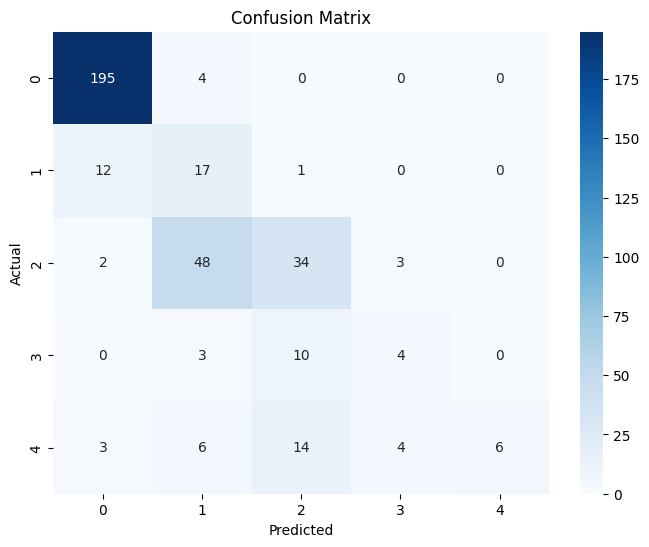

In [11]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()